# ArcFace Loss (Additive Angular Margin Loss)

## Теория ArcFace

В случае с обучением на задачу классификации первая подходящая лосс-функция, которая нам приходит в голову — Cross-Entropy. И на ней действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые трюки, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших подходов считается ArcFace (Additive Angular Margin).


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными доп. атрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация приводит к тому, что эмбеддинги распределяются по сфере единичного радиуса (и сфере радиуса s после умножения на гиперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угол между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.

![ArcFace](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKRR-YA_XR3yhIYBbkc8Zlbua0Q2WdM3gx_g&s)

**Важное пояснение:**

Строго говоря, ArcFace - не лосс, отдельный архитектурный модуль модификация SoftMax. Он реализует идею внесения геометрического отступа непосредственно в пространство признаков. Для обучения в качестве лосса используется обычная кросс-энтропия. Более конкретно по шагам:

1. Вы извлекаете эмбеддинги из бэкбона сети (предобученной модели, у которой обрезан FC-слой, если он был)
2. Эти эмбеддинги поступают в ArcFace-слой, который содержит векторы-центры для каждого класса (веса классификатора) и логику нормализации и добавления углового отступа
3. Для целевого класса ArcFace-слой преобразует косинус угла $\theta$ в $cos(\theta + m)$
4. Для остальных классов оставляет обычный косинус $cos(\theta)$
5. Эти модифицированные логиты подаются на вход стандартной функции Cross-Entropy
6. Градиенты от Cross-Entropy текут назад через ArcFace-слой к бэкбону, обучая модель извлекать эмбеддинги

Результат: модифицированные логиты с "жестким" разделением для целевого класса, а значит и более качественные эмбеддинги.

Схема:
```
[Изображение] → [Бэкбон] → [ЭМБЕДДИНГ] → [ArcFace] → [Логиты] → [CE Loss]
                    │                        │           │          
                   CNN                   Нормализация   Оценки
                                          + Angular    для всех
                                            Margin     классов
```

Для получения качественных эмбеддингов после обучения ArcFace-слой больше не нужен, и его обычно обрезают. Он нужен был только обучения модели, и поэтому часто ArcFace называю именно лоссом. Но стоит всегда держать в голове, что это некоторое упрощение, которое нужно лишь для того, чтобы проще формулировать мысли.

**Доп. литература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

## Другие лоссы

Кроме ArcFace, есть еще много разных вариантов лоссов для задачи Face Recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте в качестве дополнительного задания.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Иногда так выходит лучше, чем если обучать на каком-то одном лоссе.

# Датасет

В качестве датасета нужно использовать картинки из CelebA, выровненные при помощи своей модели из задания 1. Очень желательно их еще кропнуть таким образом, чтобы нейросети поступали на вход преимущественно только лица без какого либо фона, частей тела и прочего.

Если планируете делать дополнительное задание на Identificaton rate metric, то **обязательно разбейте заранее датасет на train/val или train/val/test.** Это нужно сделать не только на уровне кода, а на уровне папок, чтобы точно знать, на каких картинках модель обучалась, а на каких нет. Лучше заранее почитайте [ноутбук с заданием](https://colab.research.google.com/drive/15zuNdOupRFnG7oE-rFj9FsjoNTK6DYn5).

# План заданий

Итак, вот, что от вас требуется в этом задании:

* Выбрать модель (или несколько моделей) для обучения. Можно брать предобученные на ImageNet, но нельзя использовать модели, предобученные на задачу распознавания лиц.
* Обучить эту модель (модели) на CE loss. Добиться accuracy > 0.7.
* Реализовать ArcFace loss.
* Обучить модель (модели) на ArcFace loss. Добиться accuracy > 0.7.
* Написать небольшой отчет по обучению, сравнить CE loss и ArcFace loss.

**P.S. Не забывайте сохранять модели после обучения**

## Архитектура модели (Backbone)

В качестве базовой буду использовать ResNet18

In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

IMG_DIR = 'img_celeba'  # Папка с оригинальными фото (Wild)
SAVE_DIR = 'celeba_cropped_10k'
ALIGNED_DIR = 'celeba_aligned'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
import torch.nn.functional as F
from torchvision import transforms

class FaceIdentityDataset(Dataset):
    def __init__(self, csv_file, identity_file, img_dir):
        self.selected_names = pd.read_csv(csv_file)['image_id'].values
        # Загружаем identity и фильтруем только наши отобранные фото
        full_identity = pd.read_csv(identity_file, sep='\s+', header=None, names=['image_id', 'identity'])
        self.identity_map = full_identity.set_index('image_id').loc[self.selected_names]
        
        # Перекодируем ID в диапазон [0, num_classes-1]
        unique_ids = self.identity_map['identity'].unique()
        self.label_encoder = {old_id: new_id for new_id, old_id in enumerate(unique_ids)}
        self.num_classes = len(unique_ids)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.selected_names)

    def __getitem__(self, idx):
        img_id = self.selected_names[idx]
        img_path = os.path.join(self.img_dir, img_id)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label = self.label_encoder[self.identity_map.loc[img_id, 'identity']]
        
        t = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # веса ResNet18 были получены именно с такой Нормализацией
        ])
        return t(img), torch.tensor(label).long()

# Инициализация
dataset = FaceIdentityDataset('selected_names.csv', 'identity_CelebA.txt', 'celeba_aligned')
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
num_classes = dataset.num_classes

<>:8: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:8: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
C:\Users\mvkiselev\AppData\Local\Temp\ipykernel_60216\2432939150.py:8: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  full_identity = pd.read_csv(identity_file, sep='\s+', header=None, names=['image_id', 'identity'])


In [15]:
num_classes

5408

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class FaceNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        self.in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity() # Убираем стандартный классификатор
        
        # Слой эмбеддингов (промежуточный вектор признаков лица) для ArcFace
        self.embedding_layer = nn.Linear(self.in_features, 128)
        
        # Финальный слой для Cross-Entropy (в ArcFace он не используется напрямую)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x, return_embedding=False):
        feat = self.backbone(x)
        embed = self.embedding_layer(feat)
        
        # Для ArcFace нам нужны нормализованные эмбеддинги
        if return_embedding:
            return F.normalize(embed, p=2, dim=1)
        
        # Для Cross-Entropy возвращаем логиты
        return self.fc(embed)

## Реализация ArcFace Loss

In [6]:
import math

class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # input: дескрипторы лица (нормализованные)
        # weight: веса классов (нормализованные)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return F.cross_entropy(output, label)

## Цикл обучения (Training Loop)

In [7]:
num_epochs = 15
lr = 1e-4

In [10]:
model_ce = FaceNet(num_classes=num_classes).to(device)
criterion_ce = nn.CrossEntropyLoss()
optimizer_ce = optim.Adam(model_ce.parameters(), lr=lr)

history_ce_loss = []
history_ce_acc = []

for epoch in range(num_epochs):
    model_ce.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer_ce.zero_grad()
        logits = model_ce(imgs, return_embedding=False)
        loss = criterion_ce(logits, labels)
        
        loss.backward()
        optimizer_ce.step()
        
        running_loss += loss.item()
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    acc = correct / total
    history_ce_loss.append(running_loss / len(train_loader))
    history_ce_acc.append(acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {history_ce_loss[-1]:.4f} | Acc: {acc:.4f}")
    
    if acc > 0.7:
        print("Целевая точность достигнута!")
        break

torch.save(model_ce.state_dict(), 'model_ce_final.pth')

100%|██████████| 165/165 [01:39<00:00,  1.65it/s]


Epoch 1/15 | Loss: 8.6484 | Acc: 0.0003


100%|██████████| 165/165 [01:01<00:00,  2.69it/s]


Epoch 2/15 | Loss: 8.1621 | Acc: 0.0147


100%|██████████| 165/165 [01:01<00:00,  2.70it/s]


Epoch 3/15 | Loss: 7.5252 | Acc: 0.0896


100%|██████████| 165/165 [01:00<00:00,  2.73it/s]


Epoch 4/15 | Loss: 6.6417 | Acc: 0.2569


100%|██████████| 165/165 [01:00<00:00,  2.73it/s]


Epoch 5/15 | Loss: 5.5213 | Acc: 0.5091


100%|██████████| 165/165 [01:00<00:00,  2.73it/s]

Epoch 6/15 | Loss: 4.2141 | Acc: 0.7490
Целевая точность достигнута!


In [11]:
model_arc = FaceNet(num_classes=num_classes).to(device)
# Параметры s (scale) и m (margin) согласно классической статье
criterion_arc = ArcFaceLoss(in_features=128, out_features=num_classes, s=30.0, m=0.5).to(device)

# ВАЖНО: оптимизируем и модель, и веса ArcFace!
optimizer_arc = optim.Adam([
    {'params': model_arc.parameters()},
    {'params': criterion_arc.parameters()}
], lr=lr)

print("\n--- Старт обучения: ArcFace ---")
history_arc_loss = []
history_arc_acc = []

for epoch in range(num_epochs):
    model_arc.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer_arc.zero_grad()
        
        # Получаем эмбеддинг из модели
        embeddings = model_arc(imgs, return_embedding=True)
        # Считаем ArcFace Loss
        loss = criterion_arc(embeddings, labels)
        
        loss.backward()
        optimizer_arc.step()
        
        running_loss += loss.item()
        
        # Для расчета Accuracy вычисляем косинусное сходство признаков с весами лосса
        with torch.no_grad():
            # Нормализованное матричное умножение (аналог logits в ArcFace)
            logits = F.linear(F.normalize(embeddings), F.normalize(criterion_arc.weight))
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    history_arc_loss.append(running_loss / len(train_loader))
    history_arc_acc.append(acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {history_arc_loss[-1]:.4f} | Acc: {acc:.4f}")
    
    if acc > 0.7:
        print("Целевая точность достигнута!")
        break

torch.save(model_arc.state_dict(), 'model_arcface_final.pth')


--- Старт обучения: ArcFace ---


100%|██████████| 165/165 [01:01<00:00,  2.69it/s]


Epoch 1/15 | Loss: 24.9961 | Acc: 0.0002


100%|██████████| 165/165 [01:01<00:00,  2.70it/s]


Epoch 2/15 | Loss: 21.6956 | Acc: 0.0284


100%|██████████| 165/165 [01:01<00:00,  2.69it/s]


Epoch 3/15 | Loss: 19.7471 | Acc: 0.2255


100%|██████████| 165/165 [01:01<00:00,  2.69it/s]

Epoch 4/15 | Loss: 15.3155 | Acc: 0.7702
Целевая точность достигнута!


## Выводы

Удивительно, но обучение прошло быстро (цель > 0.7 достигнута быстро). Обучение с ArcFace прошло быстрее, что несколько непонятно: ведь ArcFace использует более жёсткое условие - угловой зазор. Но судя по-всему результирующая точность ArcFace будет выше (до конца числа эпох не обучал) и модель получится более точная. Ниже код, просто из спортивного интереса, визуализации TSNE - как кучкуются лица разных людей в кластеры на основе ArcFace. Судя по картинке - разные личности кучно легли, кластеры отлично разделены

In [12]:
!pip -q install seaborn

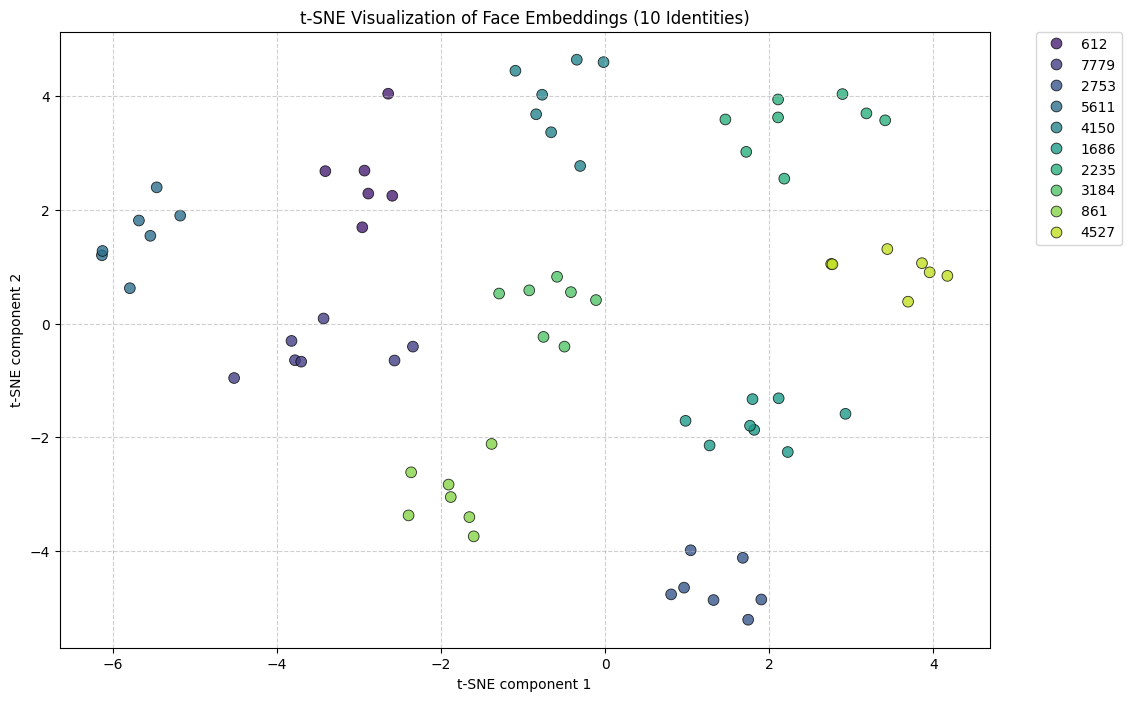

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_embeddings(model, dataset, num_identities=10, device='cpu'):
    model.eval()
    embeddings = []
    labels = []
    
    # Находим топ-N личностей с наибольшим количеством фото
    # Это нужно, чтобы кластеры были заметны
    counts = pd.Series(dataset.identity_map['identity'].values).value_counts()
    top_identities = counts.index[:num_identities].tolist()
    
    with torch.no_grad():
        for i in range(len(dataset)):
            img_id = dataset.selected_names[i]
            identity = dataset.identity_map.loc[img_id, 'identity']
            
            if identity in top_identities:
                img, label = dataset[i]
                img = img.unsqueeze(0).to(device)
                
                # Получаем нормализованный эмбеддинг
                embed = model(img, return_embedding=True)
                embeddings.append(embed.cpu().numpy()[0])
                labels.append(str(identity))
                
            if len(embeddings) >= 500:
                break

    embeddings = np.array(embeddings)
    
    tsne = TSNE(
        n_components=2, 
        perplexity=30, 
        init='pca', 
        learning_rate='auto', 
        random_state=42
    )
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], 
        hue=labels, palette='viridis', s=60, alpha=0.8, edgecolor='black'
    )
    plt.title(f't-SNE Visualization of Face Embeddings ({num_identities} Identities)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

visualize_embeddings(model_arc, dataset, num_identities=10, device=device)